In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from Auxiliaries.utils import *
import kitti as kt
from Models.pixor_net import PixorNet
from Losses.pixor_loss import Pixor_loss
from multiprocessing import Pool, cpu_count
import time
from Auxiliaries.evaluation import *
from torch.utils.tensorboard import SummaryWriter
tensorwriter = SummaryWriter("./LogsTensor/")

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = PixorNet().to(device)
criterion = Pixor_loss()
optimizer = torch.optim.Adam(net.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=1)

load_checkpoint(net, optimizer, scheduler, "./Checkpoints/final_best_detector.pth.tar")

cuda:0


(31, 110.69493813027705)

Losses 0.37815291576191434 0.0008175846887752414 0.3773353310731391


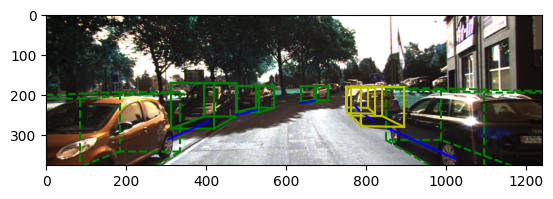

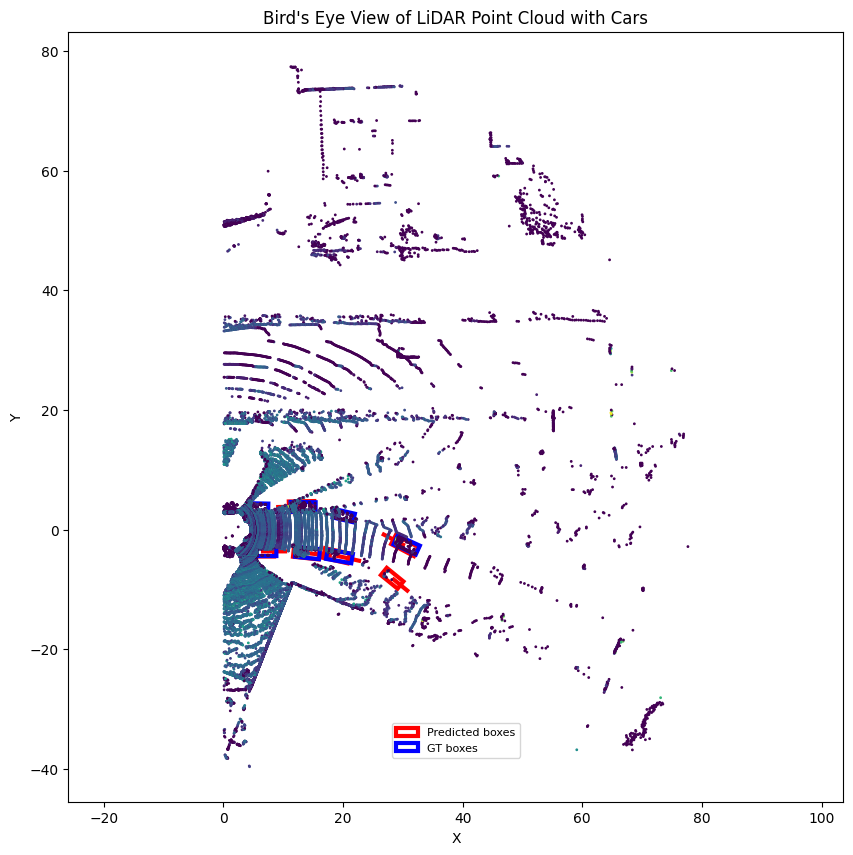

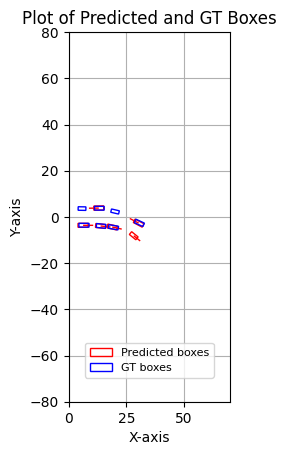

AP  0.7142857142857143


In [28]:
Kitti_train = kt.Kitti(train=True, verbose=False)

######### Test 1 sample #############
idx = 99
DETECTION_THRESH = 0.83

# for idx in range(20):
traindata = (torch.tensor(data).to(device) for data in Kitti_train[idx])
lidar_input, label, gt_boxes = traindata
lidar_input, label = lidar_input.unsqueeze(0).permute(0, 3, 1, 2), label.unsqueeze(0)
pred = net(lidar_input).permute(0, 2, 3, 1)
total_loss, cls_loss, reg_loss = criterion(pred, label)
print("Losses", total_loss.item(), cls_loss.item(), reg_loss.item())

pred = pred.cpu().detach().numpy()
gt_boxes = gt_boxes.cpu().detach().numpy()

# draw bbox agent on image
agents = Kitti_train.get_agents_only(idx)
boxcams = [Box3D_cameraview(agent) for agent in agents]
ocams = [Orientation3D_cameraview(agent) for agent in agents]
image = Kitti_train.load_image_data(Kitti_train.image_files[idx])
Projection_M = Kitti_train.load_calib_data(Kitti_train.calib_files[idx])['P']
draw_Box3D_Orientation3D_image(agents, image, boxcams, ocams, Projection_M)


bboxes, valid_pred, Orient = filter_predictions(pred.squeeze(0), DETECTION_THRESH)
winning_boxes, winning_orient = perform_nms(bboxes, valid_pred, Orient, NMS_THRESH)
raw_lidar = Kitti_train.get_raw_lidardata_only(idx)
draw_Box3D_orientation3D_on_LidarBEV(raw_lidar, winning_boxes, winning_orient, gt_boxes)
plot_gt_and_final_boxes(winning_boxes, winning_orient, gt_boxes)
print("AP ", compute_ap(winning_boxes, gt_boxes))

In [8]:
idx = 6
lidar = first_batch[0][idx]
# image = first_batch[1][idx]
# calib = first_batch[2]
label = first_batch[3][idx]

P, velo_to_cam, Ro_rect = calib['P'][idx], calib['velo_to_cam'][idx], calib['Ro_rect'][idx]
agents = Kitti_train.get_agents_only(idx)
raw_lidardata = Kitti_train.get_raw_lidardata_only(idx)

boxcams = [Box3D_cameraview(agent) for agent in agents]
ocams = [Orientation3D_cameraview(agent) for agent in agents]
Box3D_list = [Box3D_lidar_BEV(b, velo_to_cam, Ro_rect) for b in boxcams]
O3D_list = [Orientation3D_lidar_BEV(b, velo_to_cam, Ro_rect) for b in ocams]

NameError: name 'first_batch' is not defined